<a href="https://colab.research.google.com/github/baroneleonardo/NO2-Virtual-Sensor/blob/main/Kfold_GridSearch_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
data = pd.read_csv("data_dausare.csv")
#data = pd.read_excel("data_dropoutIQR.xlsx")
data = data.set_index('Datetime')
#data.describe()

In [ ]:
# Usa solo per dati dropout
data = data.drop('level_0', axis=1)
data = data.drop('Week days', axis=1)
data = data.drop('index', axis=1)
data = data.drop('Unnamed: 0', axis=1)
data = data.drop('day', axis=1)
data = data.drop('time', axis=1)

In [ ]:
data = data.dropna(subset=["NO2(GT)"])
data = data.dropna(subset=["T"])
#data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7393 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    7393 non-null   float64
 1   PT08.S2(NMHC)  7393 non-null   float64
 2   PT08.S3(NOx)   7393 non-null   float64
 3   NO2(GT)        7393 non-null   float64
 4   PT08.S5(O3)    7393 non-null   float64
 5   T              7393 non-null   float64
 6   RH             7393 non-null   float64
 7   AH             7393 non-null   float64
dtypes: float64(8)
memory usage: 519.8+ KB


In [ ]:
# Normalize the data, this is a rudimentary MinMaxScaler
max_df = data.max()
min_df = data.min()

data_norm = (data - min_df)/(max_df - min_df)
data_norm = pd.DataFrame(data_norm, columns=data.columns)

#### Talk first easy NN just to see the difference in the data-cleaning part

In [ ]:
import tensorflow as tf
import os
import random
import seaborn as sns
import matplotlib as mpl
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import L1

warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers
tf.config.set_visible_devices([], 'GPU') #disables GPU
print(tf.__version__)

2.12.0


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# just to prove that is the same as the classic MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

target = pd.DataFrame(data['NO2(GT)'])
X = data.drop(['NO2(GT)'], axis=1)
print('NO2" data_normset shape',X.shape)
print('Target shape', target.shape)
X.describe()

scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(X)
x_scaled = pd.DataFrame(x_scaled, columns=X.columns)

#do the same for y

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target) 
y_scaled = pd.DataFrame(y_scaled, columns=target.columns)


y_scaled.describe()   
x_scaled.describe()

NO2" data_normset shape (7393, 7)
Target shape (7393, 1)


,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S5(O3),T,RH,AH
count,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000,7393.000000
mean,0.333748,0.309864,0.212836,0.358246,0.427159,0.497782,0.405859
std,0.156757,0.144993,0.108836,0.176336,0.193585,0.219921,0.202238
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.217056,0.199918,0.138304,0.228956,0.283333,0.326210,0.257746
50%,0.309156,0.295917,0.198877,0.334419,0.408602,0.500629,0.390793
75%,0.430162,0.406527,0.267923,0.471924,0.558065,0.666248,0.544303
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#split in test and train

# X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size = 0.2, random_state=seed, shuffle=True)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

test_size = int(0.20*7393)

X_train = x_scaled.iloc[:-test_size]
y_train = y_scaled.iloc[:-test_size]
X_test = x_scaled.iloc[-test_size:]
y_test = y_scaled.iloc[-test_size:]


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5915, 7) (5915, 1)
(1478, 7) (1478, 1)


### K-FOLD

In [ ]:
input_shape = X_train.shape[1:]
input_shape

(7,)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import tensorflow.keras.metrics as tfk

def build_ffnn_LLL(input_shape):
    model = tf.keras.Sequential()
    model.add(tfkl.Dense(512, activation='relu', input_shape=input_shape))
    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(0.5))
    model.add(tfkl.Dense(512, activation='relu'))
    model.add(tfkl.Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tfk.MeanAbsoluteError(), tfk.RootMeanSquaredError()])

    return model

input_shape = X_train.shape[1:]
batch_size = 64
epochs = 300
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)]

# Definisci il numero di fold
num_folds = 5

# Crea gli array vuoti per memorizzare i risultati di ogni fold
mse_scores = []
mae_scores = []
rmse_scores = []

# Crea gli array di dati e target
data = np.concatenate((X_train, y_train), axis=1)

# Inizializza l'oggetto KFold
kf = KFold(n_splits=num_folds, shuffle=True)

# Itera su ogni fold
for train_index, val_index in kf.split(data):
    # Divide i dati in training set e validation set
    train_data, val_data = data[train_index], data[val_index]
    
    # Separa le features e i target
    X_train_fold, y_train_fold = train_data[:, :-1], train_data[:, -1]
    X_val_fold, y_val_fold = val_data[:, :-1], val_data[:, -1]
    
    # Costruisci il modello
    ffnn = build_ffnn_LLL(input_shape)
    
    # Addestramento del modello
    history = ffnn.fit(
        X_train_fold, y_train_fold,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=0
    )
    
    # Calcola le metriche di valutazione sul fold corrente
    mse, mae, rmse = ffnn.evaluate(X_val_fold, y_val_fold, verbose=0)
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)

# Calcola la media delle metriche di valutazione su tutti i fold
avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)
avg_rmse = np.mean(rmse_scores)

# Stampa i risultati
print("Mean Squared Error (MSE):", avg_mse)
print("Mean Absolute Error (MAE):", avg_mae)
print("Root Mean Squared Error (RMSE):", avg_rmse)


Mean Squared Error (MSE): 0.0030123243108391763
Mean Absolute Error (MAE): 0.041054383665323255
Root Mean Squared Error (RMSE): 0.0548332542181015


In [ ]:
y_pred=ffnn.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
print("MSE",mean_squared_error(y_test,y_pred))
print("R2",r2_score(y_test,y_pred))

47/47 [==============================] - 0s 4ms/step
MSE 0.008527712260277076
R2 0.6602312632699857


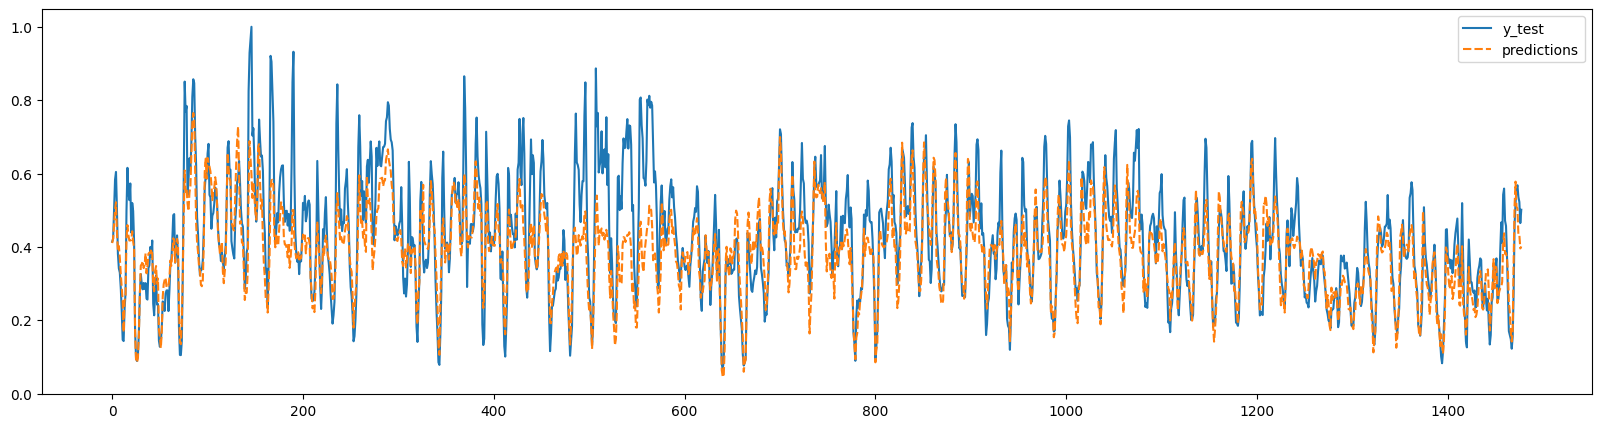

In [ ]:
aux = pd.DataFrame()
aux['y_test'] = y_test.values.flatten()
aux['predictions'] = y_pred.flatten()

plt.figure(figsize=(20, 5))
sns.lineplot(data=aux.iloc[:, :])
plt.show()

### GridSearch

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Definisci la funzione per costruire il modello FFNN
def build_ffnn(input_shape, units=512, dropout_rate=0.5, learning_rate=0.001):
    model = tf.keras.Sequential()
    model.add(tfkl.Dense(units, activation='relu', input_shape=input_shape))
    model.add(tfkl.Dense(units, activation='relu'))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.Dropout(dropout_rate))
    model.add(tfkl.Dense(units, activation='relu'))
    model.add(tfkl.Dense(1, activation='linear'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer,
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

    return model

# Definisci i parametri da testare
param_grid = {
    'units': [256, 512, 1024],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Costruisci il modello FFNN
ffnn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_ffnn, input_shape=X_train.shape[1:],
                                                           epochs=20, batch_size=64, verbose=1)

# Crea l'oggetto GridSearchCV
grid_search = GridSearchCV(estimator=ffnn_model, param_grid=param_grid, cv=5)

# Esegui la ricerca a griglia sul training set
grid_search.fit(X_train, y_train, callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='loss', save_best_only=True)])


# Stampa i migliori parametri e il punteggio corrispondente
print("Migliori parametri trovati: ", grid_search.best_params_)
print("Miglior punteggio trovato: ", grid_search.best_score_)

# Valuta il modello ottimizzato sul test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error sul test set: ", mse)
print("Mean Absolute Error sul test set: ", mae)

